In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 1000
quadrature_order       = 5
ϵ                      = 0.1
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-9
solver                 = OrdinaryDiffEq.BS5();
diff_method            = "autodiff";

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
T₀(x) = T(x,ϵ)

T₀ (generic function with 1 method)

In [6]:
dotT₀(x) = rot_double_gyre(T₀(x),nothing,t₀)

dotT₀ (generic function with 1 method)

In [7]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [8]:
M = assembleMassMatrix(ctx);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(T₀, x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

1736.152450 seconds (1.91 G allocations: 114.823 GiB, 0.82% gc time)


In [10]:
# assemble the linear response matrix L
if diff_method == "autodiff"
    Adot = x -> linear_response_tensor(T, x, 0)
elseif diff_method == "exact"
    Adot = x -> linear_response_tensor(T₀,dotT₀, x, 0)
end
@time L = assembleStiffnessMatrix(ctx, Adot);

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\yEguR\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\yEguR\src\integrator_interface.jl:345


10912.147377 seconds (3.11 G allocations: 316.011 GiB, 0.35% gc time)


In [11]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = u₀[:,i] ./ sqrt(u₀[:,i]'*M*u₀[:,i])        # L2 normalization
    u₀[:,i] = u₀[:,i] *  sign(sum(u₀[:,i]))              # fix sign
end

 25.298355 seconds (9.33 M allocations: 4.419 GiB, 1.97% gc time)


In [12]:
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2]
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

190.249476 seconds (4.35 M allocations: 4.396 GiB, 0.20% gc time)
178.273186 seconds (65.93 k allocations: 4.194 GiB, 0.28% gc time)
181.928961 seconds (307 allocations: 4.190 GiB, 0.15% gc time)
182.299936 seconds (311 allocations: 4.190 GiB, 0.24% gc time)
181.409025 seconds (307 allocations: 4.190 GiB, 0.15% gc time)
184.368803 seconds (311 allocations: 4.190 GiB, 0.22% gc time)


In [13]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
cmin_lr =  -3.1
cmax_lr =  3.1;

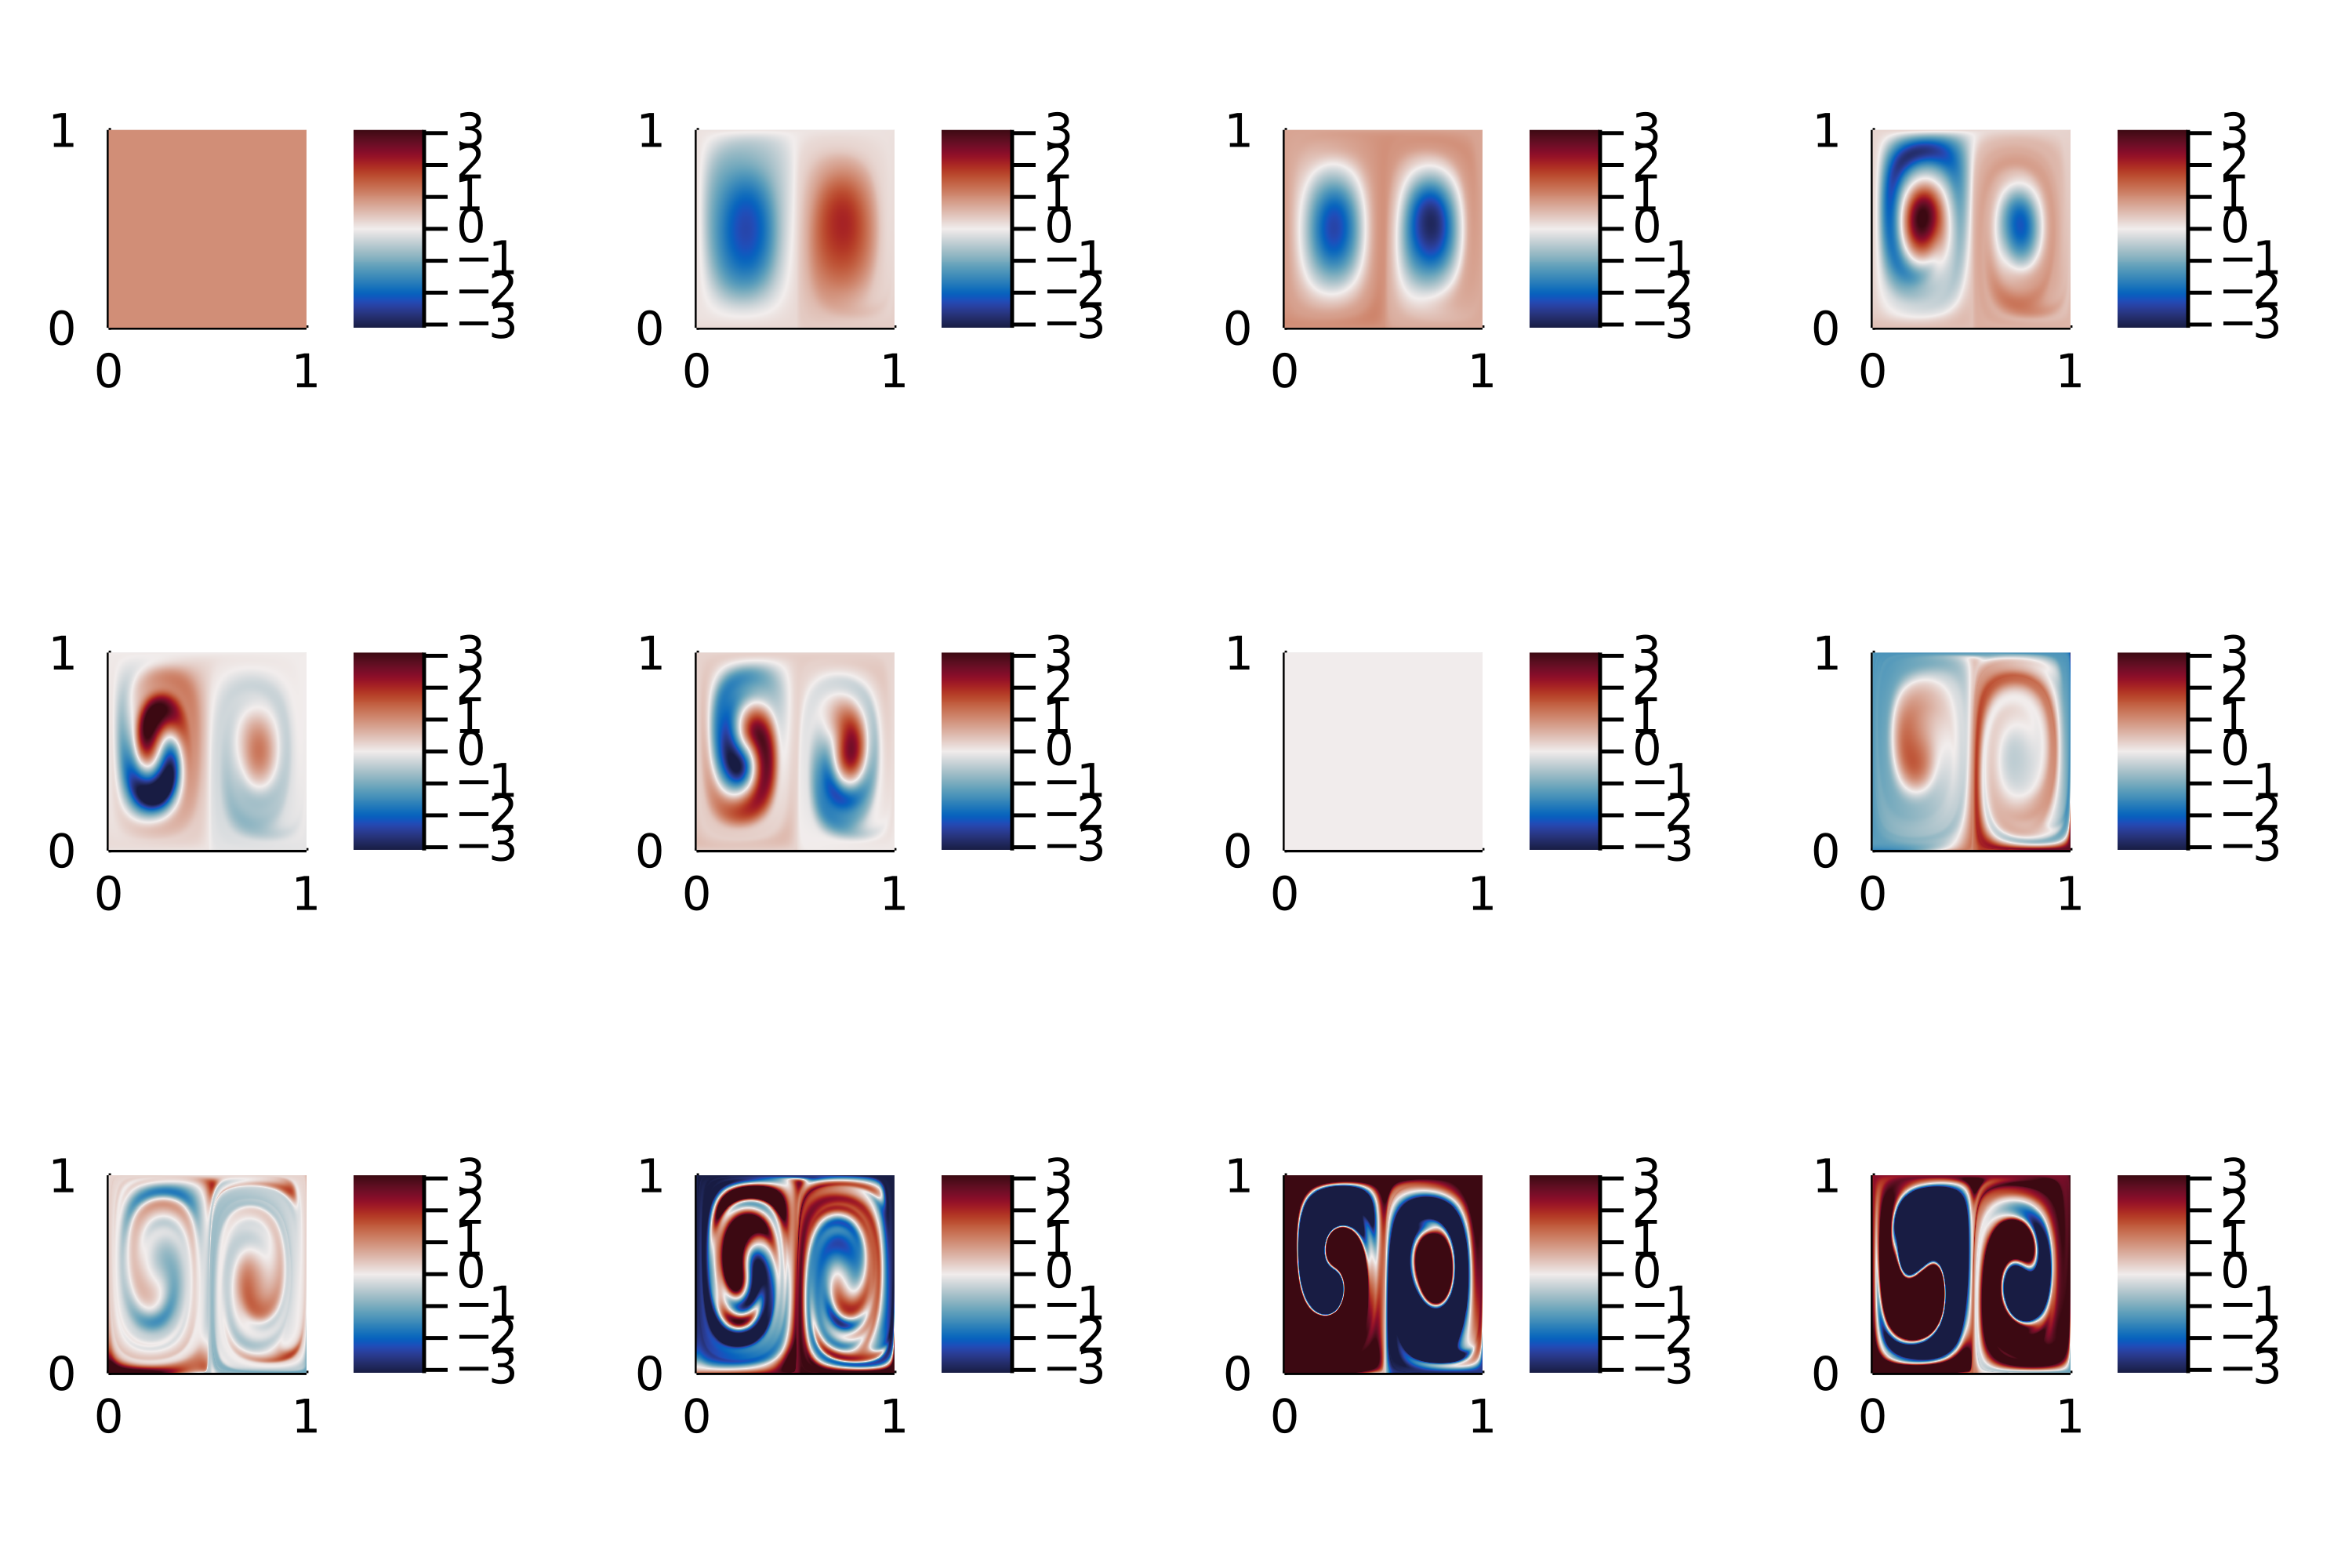

In [14]:
# plotting here is more of a sanity check
originals = []
derivatives = []
for i in 1:size(u₀)[2]
    push!(originals,  plot_u(ctx, u₀[:,i],      grid_resolution, grid_resolution, title="",
                    colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks))
    push!(derivatives,plot_u(ctx, u_dot[:,i],   grid_resolution, grid_resolution, title="",
                    colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks))
end

Plots.plot(originals...,derivatives...,fmt=:png,dpi=500)


In [15]:
using DelimitedFiles

In [16]:
if ϵ==0
    writedlm("D:/gyre_n="*string(grid_resolution)*"_tol="*string(solver_tolerance)*
        "_qo="*string(quadrature_order)*"_solver="*string(solver)*"_diff="*diff_method*"_method=CG.csv",
        [u₀  u_dot; λ₀'  λ_dot'], ",")
else
    writedlm("D:/gyre_n="*string(grid_resolution)*"_tol="*string(solver_tolerance)*
        "_qo="*string(quadrature_order)*"_solver="*string(solver)*"_diff="*diff_method*"_eps="*string(ϵ)*"_method=CG.csv",
        [u₀  u_dot; λ₀'  λ_dot'], ",")
end

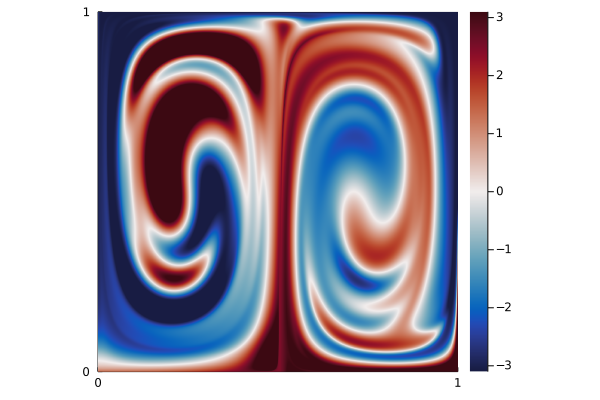

In [18]:
plot_u(ctx, u_dot[:,4],      grid_resolution, grid_resolution, title="",
                    colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)